In [1]:
FOLDER = "./"

In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [5]:
import gc
import skimage.io

Global Variables (constant value)

In [6]:
#Data path
train_dir = './data/train_keras'

In [7]:
train_size = len(os.listdir(train_dir))

print(train_size)

20580


In [8]:
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [9]:
#Count/Print train and test samples.
data_size = get_num_files(train_dir)
print('Data samples size: ', data_size)

Data samples size:  20580


In [10]:
train_labels = pd.read_csv('./data/train_labels.csv')

In [11]:
target, dog_breeds = pd.factorize(train_labels['breed'], sort = True)
train_labels['target'] = target
print(dog_breeds)

Index(['Afghan_hound', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier',
       'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel',
       'Border_collie',
       ...
       'schipperke', 'silky_terrier', 'soft', 'standard_poodle',
       'standard_schnauzer', 'toy_poodle', 'toy_terrier', 'vizsla', 'whippet',
       'wire'],
      dtype='object', length=120)


In [12]:
display(train_labels.head())

,id,breed,target
0,n02107683_4807,Bernese_mountain_dog,7
1,n02090721_936,Irish_wolfhound,36
2,n02116738_1849,African_hunting_dog,1
3,n02107142_814,Doberman,19
4,n02093991_3604,Irish_terrier,34


In [13]:
train_labels['breed'].value_counts()

Maltese_dog             252
Afghan_hound            239
Scottish_deerhound      232
Pomeranian              219
Bernese_mountain_dog    218
                       ... 
malinois                150
affenpinscher           150
kuvasz                  150
Pekinese                149
redbone                 148
Name: breed, Length: 120, dtype: int64

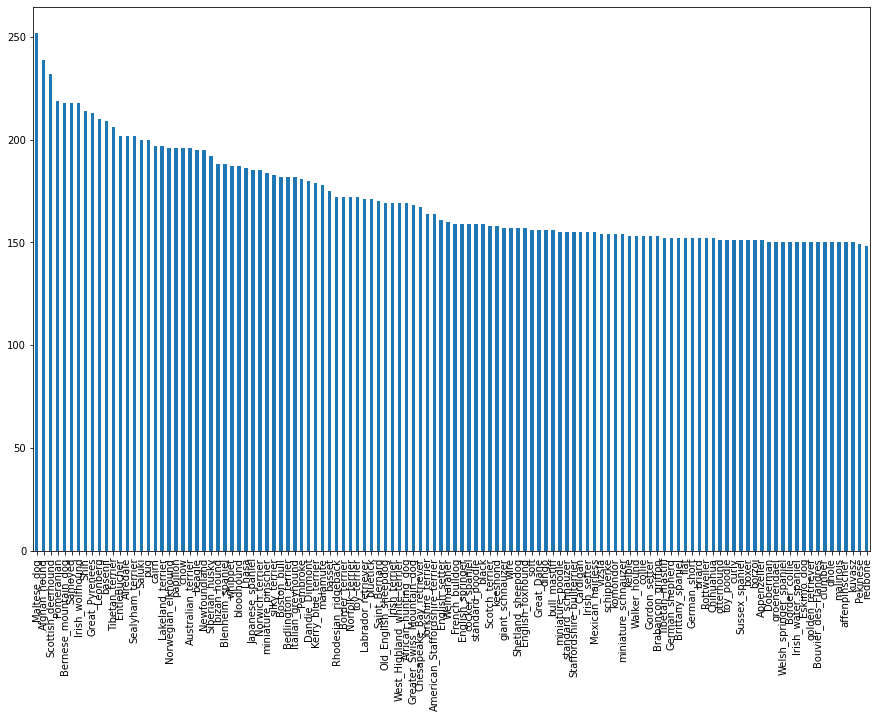

In [14]:
plt.figure(figsize=(25, 10))
train_labels['breed'].value_counts().plot(kind='bar')
plt.show()

In [15]:
#Create list of alphabetically sorted labels.
dog_breeds = sorted(list(set(train_labels['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:3]

120


['Afghan_hound', 'African_hunting_dog', 'Airedale']

In [16]:
#Map each label string to an integer label.
class_to_num = dict(zip(dog_breeds, range(n_classes)))

In [17]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):
    '''
    1- Read image samples from certain directory.
    2- Risize it, then stack them into one big numpy array.
    3- Read sample's label form the labels dataframe.
    4- One hot encode labels array.
    5- Shuffle Data and label arrays.
    '''
    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    #initailize output arrays.
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    #read data and lables.
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    #One hot encoder
    y = to_categorical(y)
    #shuffle    
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y

In [18]:
img_size = (331,331,3)
try:
  X = np.load(FOLDER + "X_save.npy")
  y = np.load(FOLDER + "y_save.npy")
  print(len(X), len(y))
except: 
  #img_size chosen to be 331 to suit the used architectures.
  X, y = images_to_array(train_dir, train_labels, img_size)
  np.save(FOLDER + "X_save", X)
  np.save(FOLDER + "y_save", y)

20580 20580


In [19]:
def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    print(feature_extractor)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=128, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [20]:
# Extract features using InceptionV3 as extractor.
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

161/161 [==============================] - 803s 5s/step
Feature maps shape:  (20580, 2048)


In [21]:
# Extract features using Xception as extractor.
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

 41/161 [======>.......................] - ETA: 16:57

In [ ]:
# Extract features using NASNetLarge as extractor.
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

In [ ]:
# Extract features using InceptionResNetV2 as extractor.
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

In [ ]:
#It's a good habit to free up some RAM memory.
#X variable won't be needed anymore, so let's get rid of it.
del X

In [ ]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1)
print('Final feature maps shape', final_features.shape)

In [ ]:
final_features.shape[1:]

In [ ]:
final_features

In [ ]:
from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [ ]:
#Prepare DNN model
dnn = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
dnn.summary()

In [ ]:
#Train simple DNN on extracted features.
h = dnn.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=my_callback)

In [ ]:
class DogBreedClassification():
  def __init__(self, model_list, processor_list, input_size):
    self.model_list = model_list
    self.processor_list = processor_list
    self.input_size = input_size
    print("image_size: ", image_size)


  def get_features(self, model_name, data_preprocessor, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(self.input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    print(feature_extractor)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=128, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

  def extract_features(self, data):
    model_and_processor = zip(self.model_list, self.processor_list)
    feature_list = []
    for model, preprocessor in model_and_processor:
      feature_list.append(self.get_features(model, preprocessor, data))
    final_features = np.concatenate(feature_list, axis=-1)
    return final_features

  def _make_dnn_model(self):
    dnn = keras.models.Sequential([
      InputLayer(final_features.shape[1:]),
      Dropout(0.7),
      Dense(n_classes, activation='softmax')
      ])
    dnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    self.dnn = dnn

In [ ]:
train_X = X[:16000]
train_y = y[:16000]
val_X = X[16000:]
val_y = y[16000:]
train_X.shape, val_X.shape